In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import matplotlib

# import warnings
import colorcet as cc
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import celeri

# Read data and pre-process

In [3]:
COMMAND_FILE_NAME = "../data/command/japan_command_cmi_coupling.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

INFO: Read: ../data/command/japan_command_cmi_coupling.json - celeri.celeri:get_logger:7622 - 2024-12-09 15:49:22
INFO: RUN_NAME: 0000000727 - celeri.celeri:get_logger:7623 - 2024-12-09 15:49:22
INFO: Write log file: ../runs/0000000727/0000000727.log - celeri.celeri:get_logger:7624 - 2024-12-09 15:49:22
INFO: Reading data files - celeri.celeri:read_data:451 - 2024-12-09 15:49:22
SUCCESS: Read: ../data/segment/qp_japan_segment.csv - celeri.celeri:read_data:455 - 2024-12-09 15:49:22
SUCCESS: Read: ../data/block/japan_block.csv - celeri.celeri:read_data:460 - 2024-12-09 15:49:22
SUCCESS: Read: ../data/mesh/japan_mesh_parameters_cmi_coupling.json - celeri.celeri:read_data:467 - 2024-12-09 15:49:22

SUCCESS: Read: ../data/mesh/nankai.msh - celeri.celeri:read_mesh:446 - 2024-12-09 15:49:22

SUCCESS: Read: ../data/mesh/japan.msh - celeri.celeri:read_mesh:446 - 2024-12-09 15:49:22

SUCCESS: Read: ../data/mesh/sagami.msh - celeri.celeri:read_mesh:446 - 2024-12-09 15:49:22

SUCCESS: Read: ../dat

# Generate all operators, weighting, and data vector for KL+QP problem

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Block rotation to velocity operator
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)

# Soft block motion constraints
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)

# Soft slip rate constraints
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)

# Rotation vectors to slip rate operator
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

# Internal block strain rate operator
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)

# Mogi source operator
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)

# Soft TDE boundary condition constraints
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Get index
index = celeri.get_index_eigen(assembly, segment, station, block, meshes, mogi)

# Get data vector for KL problem
data_vector_eigen = celeri.get_data_vector_eigen(meshes, assembly, index)

# Get data vector for KL problem
weighting_vector_eigen = celeri.get_weighting_vector_eigen(
    command, station, meshes, index
)

# Get KL modes for each mesh
celeri.get_eigenvectors_to_tde_slip(operators, meshes)

# Get full operator including all blocks, KL modes, strain blocks, and mogis
operators.eigen = celeri.get_full_dense_operator_eigen(operators, meshes, index)

# Get rotation to TDE kinematic slip rate operator for all meshes tied to segments
celeri.get_tde_coupling_constraints(meshes, segment, block, operators)

INFO: Using precomputed elastic operators - celeri.celeri:get_elastic_operators:2038 - 2024-12-09 15:49:22
INFO: No slip rate constraints - celeri.celeri:get_slip_rate_constraints:3356 - 2024-12-09 15:49:23
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-12-09 15:49:23
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4485 - 2024-12-09 15:49:23
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-12-09 15:49:23
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4485 - 2024-12-09 15:49:25
INFO: Start: Eigenvectors to TDE slip for mesh: ../data/mesh/sagami.msh - celeri.celeri:get_eigenvectors_to_tde_slip:4456 - 2024-12-09 15:49:25
SUCCESS: Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/sa

# Solve bounded KL+QP problem

In [5]:
# Get QP bounds as inequality constraints
qp_inequality_constraints_matrix, qp_inequality_constraints_data_vector = (
    celeri.get_qp_all_inequality_operator_and_data_vector(
        index, meshes, operators, segment, block
    )
)

# QP solve
opts = {"show_progress": True}
solution_qp = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_inequality_constraints_matrix,  # Inequality matrix
    qp_inequality_constraints_data_vector,  # Inequality data vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Create estimation data structure and calculate derived quantities
estimation_qp = addict.Dict()
estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
estimation_qp.operator = operators.eigen
celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

INFO: No hard slip rate bounds - celeri.celeri:get_slip_rate_bounds:4153 - 2024-12-09 15:49:25
     pcost       dcost       gap    pres   dres
 0: -2.9506e+04 -2.9872e+07  3e+07  5e-17  1e-15
 1: -4.3939e+04 -7.2012e+06  7e+06  2e-16  1e-15
 2: -4.3712e+04 -6.7968e+06  7e+06  3e-16  7e-16
 3: -4.4926e+04 -1.1108e+06  1e+06  2e-16  5e-16
 4: -4.7548e+04 -2.1987e+05  2e+05  2e-16  6e-16
 5: -4.9542e+04 -7.0844e+04  2e+04  2e-16  1e-15
 6: -5.0288e+04 -5.3062e+04  3e+03  2e-16  7e-16
 7: -5.0475e+04 -5.1019e+04  5e+02  3e-16  1e-15
 8: -5.0517e+04 -5.0794e+04  3e+02  3e-16  5e-16
 9: -5.0529e+04 -5.0698e+04  2e+02  3e-16  4e-16
10: -5.0533e+04 -5.0652e+04  1e+02  3e-16  4e-16
11: -5.0536e+04 -5.0591e+04  5e+01  3e-16  5e-16
12: -5.0537e+04 -5.0570e+04  3e+01  3e-16  3e-16
13: -5.0538e+04 -5.0550e+04  1e+01  3e-16  4e-16
14: -5.0538e+04 -5.0544e+04  6e+00  3e-16  4e-16
15: -5.0538e+04 -5.0541e+04  3e+00  3e-16  5e-16
16: -5.0538e+04 -5.0539e+04  7e-01  3e-16  4e-16
17: -5.0538e+04 -5.0538e

# Plot KL+QP estimation

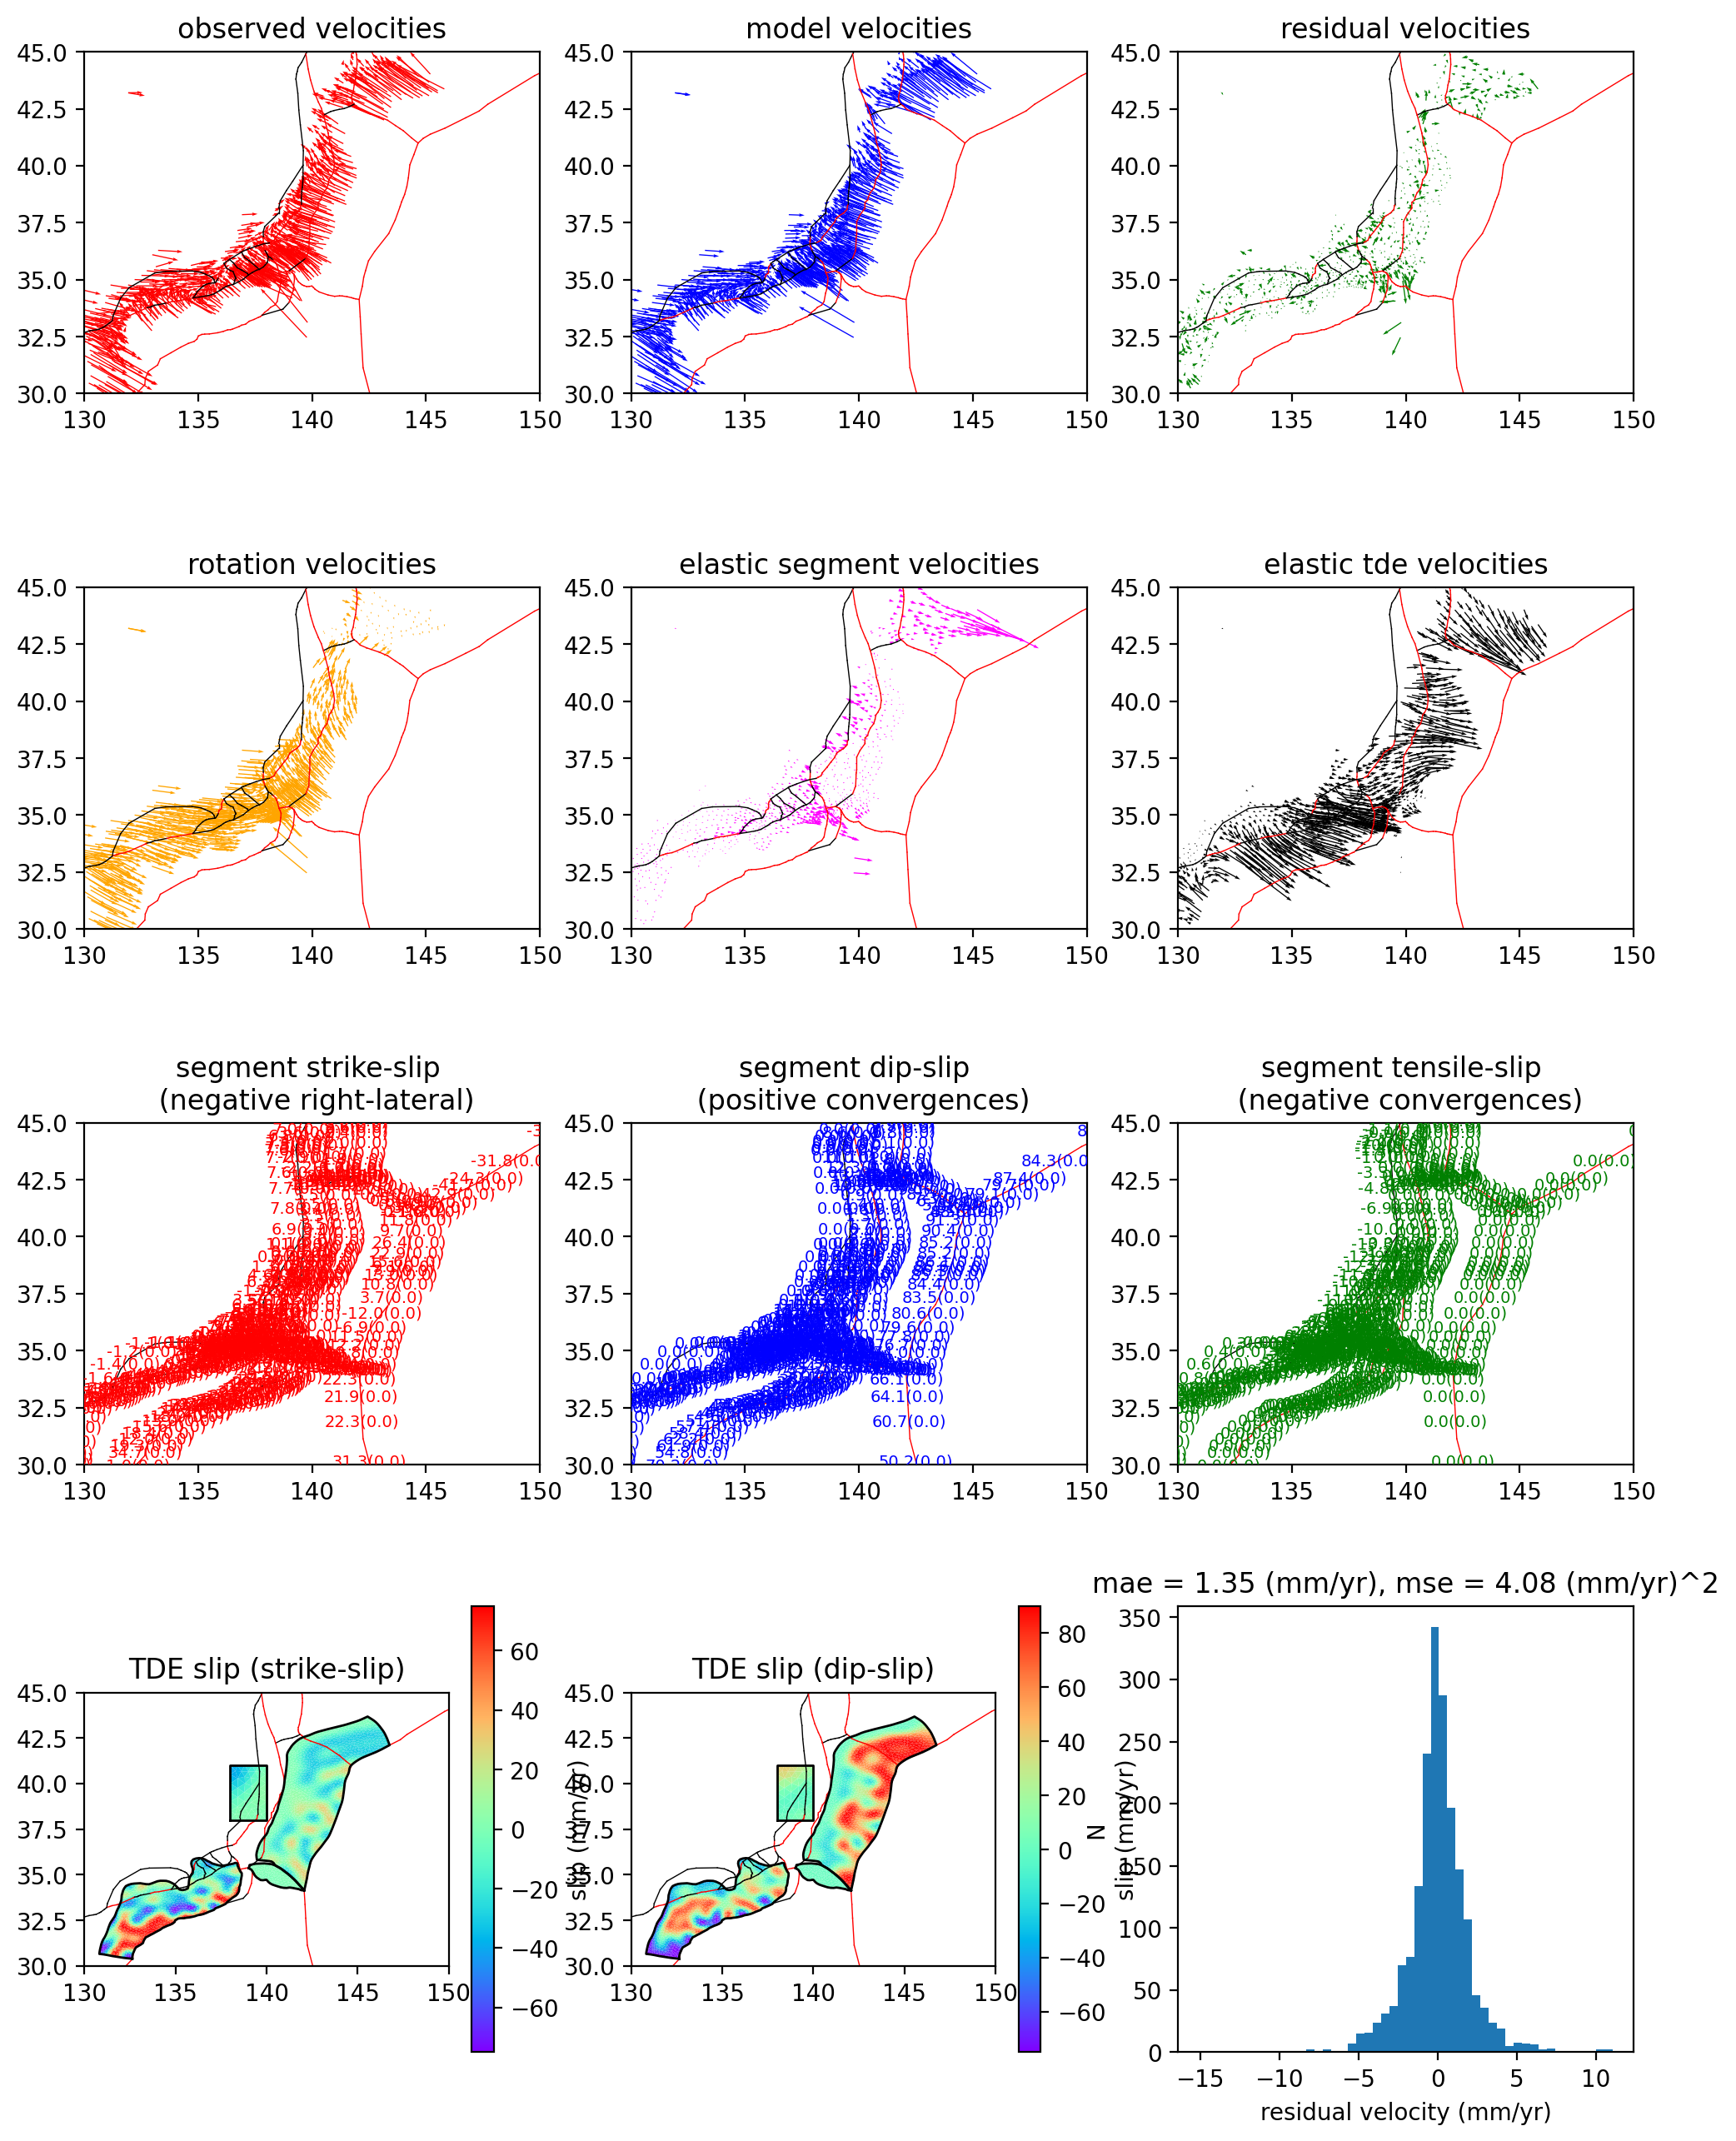

SUCCESS: Wrote figures../runs/0000000727/plot_estimation_summary.(pdf, png) - celeri.celeri:plot_estimation_summary:6663 - 2024-12-09 15:49:29


<Figure size 640x480 with 0 Axes>

In [6]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Helper functions
- mesh plotting
- mesh smoothing

In [7]:
def plot_mesh(meshes, fill_value, ax):
    x_coords = meshes.points[:, 0]
    y_coords = meshes.points[:, 1]
    vertex_array = np.asarray(meshes.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(verts, edgecolor="none", cmap="rainbow")
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.colorbar(pc, fraction=0.046, pad=0.04)

    # Add mesh edge
    x_edge = x_coords[meshes.ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes.ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes.ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes.ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=1)
    plt.gca().set_aspect("equal")


def smooth_irregular_data(x_coords, y_coords, values, length_scale):
    # Build a KDTree for efficient neighbor searching
    points = np.vstack((x_coords, y_coords)).T
    tree = cKDTree(points)

    # Prepare an array to store the smoothed values
    smoothed_values = np.zeros_like(values)

    # Smoothing calculation
    for i, point in enumerate(points):
        # Find neighbors within 3 * length_scale for efficiency
        indices = tree.query_ball_point(point, 3 * length_scale)

        # Calculate distances and apply Gaussian weights
        distances = np.linalg.norm(points[indices] - point, axis=1)
        weights = np.exp(-(distances**2) / (2 * length_scale**2))

        # Weighted sum for smoothing
        smoothed_values[i] = np.sum(weights * values[indices]) / np.sum(weights)

    return smoothed_values

# Iterative approach to finding a solution within coupling bounds

In [8]:
def get_coupling(
    x1,
    x2,
    estimated_slip,
    kinematic_slip,
    smoothing_length_scale,
    kinematic_slip_regularization_scale,
):
    """
    Calculate coupling with optional smoothing and regularization
    """

    # Smooth kinematic rates
    if smoothing_length_scale > 0.0:
        kinematic_slip = smooth_irregular_data(
            x1,
            x2,
            kinematic_slip,
            length_scale=smoothing_length_scale,
        )

    # Set the minimum value of the kinematic rates
    # The purpose of this is to prevent coupling blow up as the kinematic
    # rates approach zero
    if kinematic_slip_regularization_scale > 0:
        kinematic_slip[np.abs(kinematic_slip) < kinematic_slip_regularization_scale] = (
            kinematic_slip_regularization_scale
            * np.sign(
                kinematic_slip[
                    np.abs(kinematic_slip) < kinematic_slip_regularization_scale
                ]
            )
        )

    # Calculate coupling
    coupling = estimated_slip / kinematic_slip

    return coupling, kinematic_slip


def update_slip_rate_bounds(
    mesh_idx,
    tde_coupling_ss,
    tde_coupling_ds,
    kinematic_tde_rates_ss,
    kinematic_tde_rates_ds,
    current_ss_bounds_lower,
    current_ss_bounds_upper,
    current_ds_bounds_lower,
    current_ds_bounds_upper,
):
    print(f"update_slip_rate_bounds {mesh_idx=}")
    tde_coupling_ss_lower_oob_idx = np.where(
        tde_coupling_ss < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
    )[0]

    tde_coupling_ss_upper_oob_idx = np.where(
        tde_coupling_ss > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
    )[0]

    tde_coupling_ds_lower_oob_idx = np.where(
        tde_coupling_ds < meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
    )[0]

    tde_coupling_ds_upper_oob_idx = np.where(
        tde_coupling_ds > meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
    )[0]

    # Find indices of mesh elements with negative kinematic rate
    neg_jpl_ss_idx = np.where(kinematic_tde_rates_ss < 0)[0]
    neg_jpl_ds_idx = np.where(kinematic_tde_rates_ds < 0)[0]
    pos_jpl_ss_idx = np.where(kinematic_tde_rates_ss >= 0)[0]
    pos_jpl_ds_idx = np.where(kinematic_tde_rates_ds >= 0)[0]

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ss lower bounds
    tde_coupling_ss_lower_oob_and_neg_jpl_ss = np.intersect1d(
        tde_coupling_ss_lower_oob_idx, neg_jpl_ss_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ss upper bounds
    tde_coupling_ss_upper_oob_and_neg_jpl_ss = np.intersect1d(
        tde_coupling_ss_upper_oob_idx, neg_jpl_ss_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ds lower bounds
    tde_coupling_ds_lower_oob_and_neg_jpl_ds = np.intersect1d(
        tde_coupling_ds_lower_oob_idx, neg_jpl_ds_idx
    )

    # NEGATIVE CASE: Find intersection of indices with negative kinematic rates and OOB ds upper bounds
    tde_coupling_ds_upper_oob_and_neg_jpl_ds = np.intersect1d(
        tde_coupling_ds_upper_oob_idx, neg_jpl_ds_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ss lower bounds
    tde_coupling_ss_lower_oob_and_pos_jpl_ss = np.intersect1d(
        tde_coupling_ss_lower_oob_idx, pos_jpl_ss_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ss upper bounds
    tde_coupling_ss_upper_oob_and_pos_jpl_ss = np.intersect1d(
        tde_coupling_ss_upper_oob_idx, pos_jpl_ss_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ds lower bounds
    tde_coupling_ds_lower_oob_and_pos_jpl_ds = np.intersect1d(
        tde_coupling_ds_lower_oob_idx, pos_jpl_ds_idx
    )

    # POSITIVE CASE: Find intersection of indices with positive kinematic rates and OOB ds upper bounds
    tde_coupling_ds_upper_oob_and_pos_jpl_ds = np.intersect1d(
        tde_coupling_ds_upper_oob_idx, pos_jpl_ds_idx
    )

    # Calculate total number of OOB coupling constraints
    n_oob = (
        len(tde_coupling_ss_lower_oob_idx)
        + len(tde_coupling_ss_upper_oob_idx)
        + len(tde_coupling_ds_lower_oob_idx)
        + len(tde_coupling_ds_upper_oob_idx)
    )

    # Make vectors for update slip rates (not neccesary but useful for debugging)
    updated_ss_bounds_lower = np.copy(current_ss_bounds_lower)
    updated_ss_bounds_upper = np.copy(current_ss_bounds_upper)
    updated_ds_bounds_lower = np.copy(current_ds_bounds_lower)
    updated_ds_bounds_upper = np.copy(current_ds_bounds_upper)

    # Calculate midpoint slip rate assciated with midpoint coupling
    mid_point_ss_coupling = 0.5 * (
        meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ss_coupling
        + meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ss_coupling
    )
    mid_point_ds_coupling = 0.5 * (
        meshes[mesh_idx].qp_mesh_tde_slip_rate_lower_bound_ds_coupling
        + meshes[mesh_idx].qp_mesh_tde_slip_rate_upper_bound_ds_coupling
    )
    mid_point_ss_rate = mid_point_ss_coupling * kinematic_tde_rates_ss
    mid_point_ds_rate = mid_point_ds_coupling * kinematic_tde_rates_ds

    # Calculate new slip rate bounds
    new_ss_bounds_lower = current_ss_bounds_lower + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ss_rate - current_ss_bounds_lower
    )

    new_ss_bounds_upper = current_ss_bounds_upper + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ss_rate - current_ss_bounds_upper
    )

    new_ds_bounds_lower = current_ds_bounds_lower + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ds_rate - current_ds_bounds_lower
    )

    new_ds_bounds_upper = current_ds_bounds_upper + meshes[
        mesh_idx
    ].iterative_coupling_linear_slip_rate_reduction_factor * (
        mid_point_ds_rate - current_ds_bounds_upper
    )

    # Update slip rate bounds
    # NOTE: Note upper and lower swap here for negative kinmatic cases (2nd and 3rd quadrants)
    # Negative kinematic case
    updated_ss_bounds_lower[tde_coupling_ss_upper_oob_and_neg_jpl_ss] = (
        new_ss_bounds_lower[tde_coupling_ss_upper_oob_and_neg_jpl_ss]
    )
    updated_ss_bounds_upper[tde_coupling_ss_lower_oob_and_neg_jpl_ss] = (
        new_ss_bounds_upper[tde_coupling_ss_lower_oob_and_neg_jpl_ss]
    )
    updated_ds_bounds_lower[tde_coupling_ds_upper_oob_and_neg_jpl_ds] = (
        new_ds_bounds_lower[tde_coupling_ds_upper_oob_and_neg_jpl_ds]
    )
    updated_ds_bounds_upper[tde_coupling_ds_lower_oob_and_neg_jpl_ds] = (
        new_ds_bounds_upper[tde_coupling_ds_lower_oob_and_neg_jpl_ds]
    )

    # Positive kinematic case
    updated_ss_bounds_lower[tde_coupling_ss_lower_oob_and_pos_jpl_ss] = (
        new_ss_bounds_lower[tde_coupling_ss_lower_oob_and_pos_jpl_ss]
    )
    updated_ss_bounds_upper[tde_coupling_ss_upper_oob_and_pos_jpl_ss] = (
        new_ss_bounds_upper[tde_coupling_ss_upper_oob_and_pos_jpl_ss]
    )
    updated_ds_bounds_lower[tde_coupling_ds_lower_oob_and_pos_jpl_ds] = (
        new_ds_bounds_lower[tde_coupling_ds_lower_oob_and_pos_jpl_ds]
    )
    updated_ds_bounds_upper[tde_coupling_ds_upper_oob_and_pos_jpl_ds] = (
        new_ds_bounds_upper[tde_coupling_ds_upper_oob_and_pos_jpl_ds]
    )

    return (
        n_oob,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
    )


def check_coupling_bounds_single_mesh(
    meshes,
    mesh_idx,
    estimation_qp,
    current_ss_bounds_lower,
    current_ss_bounds_upper,
    current_ds_bounds_lower,
    current_ds_bounds_upper,
):
    print(f"check_coupling_bounds_single_mesh, {mesh_idx=}")
    # Get kinematic rates on mesh elements
    kinematic_tde_rates = (
        operators.rotation_to_tri_slip_rate[mesh_idx]
        @ estimation_qp.state_vector[0 : 3 * len(block)]
    )

    # Get estimated elastic rates on mesh elements
    estimated_tde_rates = (
        operators.eigenvectors_to_tde_slip[mesh_idx]
        @ estimation_qp.state_vector[
            3 * len(block) : 3 * len(block)
            + (meshes[mesh_idx].n_modes_strike_slip + meshes[mesh_idx].n_modes_dip_slip)
        ]
    )

    # Calculate strike-slip and dip-slip coupling
    tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        estimated_tde_rates[0::2],
        kinematic_tde_rates[0::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        estimated_tde_rates[1::2],
        kinematic_tde_rates[1::2],
        smoothing_length_scale=meshes[
            mesh_idx
        ].iterative_coupling_smoothing_length_scale,
        kinematic_slip_regularization_scale=meshes[
            mesh_idx
        ].iterative_coupling_kinematic_slip_regularization_scale,
    )

    # Update slip rate bounds
    (
        n_oob,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
    ) = update_slip_rate_bounds(
        mesh_idx,
        tde_coupling_ss,
        tde_coupling_ds,
        kinematic_tde_rates_ss_smooth,
        kinematic_tde_rates_ds_smooth,
        current_ss_bounds_lower,
        current_ss_bounds_upper,
        current_ds_bounds_lower,
        current_ds_bounds_upper,
    )

    # Determine whether or not updating is required
    if n_oob > 0:
        continue_iterate_for_coupling_bounds = True
    else:
        continue_iterate_for_coupling_bounds = False

    return (
        continue_iterate_for_coupling_bounds,
        updated_ss_bounds_lower,
        updated_ss_bounds_upper,
        updated_ds_bounds_lower,
        updated_ds_bounds_upper,
        kinematic_tde_rates_ss_smooth,
        kinematic_tde_rates_ds_smooth,
        estimated_tde_rates[0::2],
        estimated_tde_rates[1::2],
        n_oob,
    )

In [ ]:
# Get total number of segment meshes.
# The tolist() is to cast to an int rather than a int64
# so that it's json serializable.  Can't believe this.
n_segment_meshes = np.max(segment.patch_file_name).astype(int)


# TODO: I THINK THIS SHOULD be inside the mesh for loop???
# Set tracking for each
current_ss_bounds_lower = meshes[0].qp_mesh_tde_slip_rate_lower_bound_ss * np.ones(
    meshes[0].n_tde
)
current_ss_bounds_upper = meshes[0].qp_mesh_tde_slip_rate_upper_bound_ss * np.ones(
    meshes[0].n_tde
)
current_ds_bounds_lower = meshes[0].qp_mesh_tde_slip_rate_lower_bound_ds * np.ones(
    meshes[0].n_tde
)
current_ds_bounds_upper = meshes[0].qp_mesh_tde_slip_rate_upper_bound_ds * np.ones(
    meshes[0].n_tde
)

# Start relaxation iterations
n_iter = 11
n_oob_vec = np.zeros((n_segment_meshes, n_iter))
store_ss_lower = np.zeros((meshes[0].n_tde, n_iter))
store_ss_upper = np.zeros((meshes[0].n_tde, n_iter))
store_ds_lower = np.zeros((meshes[0].n_tde, n_iter))
store_ds_upper = np.zeros((meshes[0].n_tde, n_iter))
store_ss_jpl = np.zeros((meshes[0].n_tde, n_iter))
store_ss_bjm = np.zeros((meshes[0].n_tde, n_iter))
store_ds_jpl = np.zeros((meshes[0].n_tde, n_iter))
store_ds_bjm = np.zeros((meshes[0].n_tde, n_iter))


for i in range(n_iter):

    # TODO: START: Loop over meshes
    for j in range(n_segment_meshes):
        if i == 0:
            # Read initial slip rate bounds for each mesh
            current_ss_bounds_lower = meshes[
                j
            ].qp_mesh_tde_slip_rate_lower_bound_ss * np.ones(meshes[j].n_tde)
            current_ss_bounds_upper = meshes[
                j
            ].qp_mesh_tde_slip_rate_upper_bound_ss * np.ones(meshes[j].n_tde)
            current_ds_bounds_lower = meshes[
                j
            ].qp_mesh_tde_slip_rate_lower_bound_ds * np.ones(meshes[j].n_tde)
            current_ds_bounds_upper = meshes[
                j
            ].qp_mesh_tde_slip_rate_upper_bound_ds * np.ones(meshes[j].n_tde)

        # Check if coupling bounds are met and update slip rate bounds if not
        (
            continue_iterate_for_coupling_bounds,
            updated_ss_bounds_lower,
            updated_ss_bounds_upper,
            updated_ds_bounds_lower,
            updated_ds_bounds_upper,
            kinematic_tde_rates_ss,
            kinematic_tde_rates_ds,
            estimated_tde_rates_ss,
            estimated_tde_rates_ds,
            n_oob,
        ) = check_coupling_bounds_single_mesh(
            meshes,
            j,  # This is the mesh index
            estimation_qp,
            current_ss_bounds_lower,
            current_ss_bounds_upper,
            current_ds_bounds_lower,
            current_ds_bounds_upper,
        )
        logger.info(f"Iteration: {i}, Mesh: {j}, NOOB: {n_oob}")

        # Store total number of OOB elements at this iteration step
        # TODO: NEED TO CREATE DATA STRUCTAURE FOR THIS
        n_oob_vec[j, i] = n_oob

        # Build and insert update slip rate bounds into QP inequality vector
        updated_lower_bounds = -1.0 * celeri.interleave2(
            updated_ss_bounds_lower, updated_ds_bounds_lower
        )
        updated_upper_bounds = celeri.interleave2(
            updated_ss_bounds_upper, updated_ds_bounds_upper
        )
        updated_bounds = np.hstack((updated_lower_bounds, updated_upper_bounds))

        # Insert updated bounds into data vector for ineqaulity constraints
        updated_qp_inequality_constraints_data_vector = np.copy(
            qp_inequality_constraints_data_vector
        )

        # Insert TDE lower bounds into QP constraint data vector
        updated_qp_inequality_constraints_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[
                j
            ] : index.qp_constraint_tde_rate_start_row_eigen[j]
            + 2 * index.n_tde[j]
        ] = updated_lower_bounds

        # Insert TDE upper bounds into QP constraint data vector
        updated_qp_inequality_constraints_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[j]
            + 2 * index.n_tde[j] : index.qp_constraint_tde_rate_end_row_eigen[j]
        ] = updated_upper_bounds

    # TODO: END: Loop over meshes

    # QP solve with updated TDE slip rate constraints
    solution_qp = celeri.lsqlin_qp(
        operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
        data_vector_eigen * np.sqrt(weighting_vector_eigen),
        0,
        qp_inequality_constraints_matrix,  # Inequality matrix
        updated_qp_inequality_constraints_data_vector,  # Inequality data vector
        None,
        None,
        None,
        None,
        None,
        {"show_progress": False},
    )

    # Create estimation data structure and calculate derived quantities
    estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
    estimation_qp.operator = operators.eigen
    celeri.post_process_estimation_eigen(estimation_qp, operators, station, index)

    # Set *updated* to *current* for next iteration
    current_ss_bounds_lower = np.copy(updated_ss_bounds_lower)
    current_ss_bounds_upper = np.copy(updated_ss_bounds_upper)
    current_ds_bounds_lower = np.copy(updated_ds_bounds_lower)
    current_ds_bounds_upper = np.copy(updated_ds_bounds_upper)

    # TODO: NEED TO FIGURE THIS OUT FOR MULTIPLE MESHES
    # Store values for understanding
    store_ss_lower[:, i] = current_ss_bounds_lower
    store_ss_upper[:, i] = current_ss_bounds_upper
    store_ds_lower[:, i] = current_ds_bounds_lower
    store_ds_upper[:, i] = current_ds_bounds_upper
    store_ss_bjm[:, i] = estimation_qp.tde_strike_slip_rates[0 : meshes[0].n_tde]
    store_ds_bjm[:, i] = estimation_qp.tde_dip_slip_rates[0 : meshes[0].n_tde]
    store_ss_jpl[:, i] = kinematic_tde_rates_ss
    store_ds_jpl[:, i] = kinematic_tde_rates_ds

# Write output
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

# Plot convergence
plt.figure()
plt.plot(n_oob_vec, "-r", linewidth=1.0)
plt.xlabel("iteration")
plt.ylabel("$n_\mathrm{OOB}$")
plt.show()

check_coupling_bounds_single_mesh, mesh_idx=0
update_slip_rate_bounds mesh_idx=0
INFO: Iteration: 0, Mesh: 0, NOOB: 2877 - __main__:<module>:75 - 2024-12-09 15:49:29
check_coupling_bounds_single_mesh, mesh_idx=1
update_slip_rate_bounds mesh_idx=1
INFO: Iteration: 0, Mesh: 1, NOOB: 3259 - __main__:<module>:75 - 2024-12-09 15:49:29


ValueError: could not broadcast input array from shape (2621,) into shape (1902,)

In [ ]:
range(n_segment_meshes)

# Plot convergence with iterations

In [ ]:
# Plot convergence
plt.figure(figsize=(4, 4))
# plt.plot(np.sqrt(n_oob_vec), "-r", linewidth=1.0)

plt.plot(np.sqrt(n_oob_vec / (2 * meshes[0].n_tde) * 100), "-r", linewidth=1.0)

plt.xlabel("iteration")
plt.ylabel("$\sqrt{\% \mathrm{OOB}}$")
plt.xlim([0, n_iter - 1])
plt.ylim([0, 10])

plt.show()

In [ ]:
REGULARIZATION_RATE = 1.0
LINE_COLOR = "lightgray"

levels = 101
j_cutoff = 50.0
j = np.linspace(-100, 100, 1000)
b = np.linspace(-100, 100, 1000)
j_grid, b_grid = np.meshgrid(j, b)
j_grid_orig = np.copy(j_grid)
b_grid_orig = np.copy(b_grid)
coupling, _ = get_coupling(
    0,
    0,
    b_grid.flatten(),
    j_grid.flatten(),
    smoothing_length_scale=0.0,
    kinematic_slip_regularization_scale=REGULARIZATION_RATE,
)
coupling_grid = np.reshape(coupling, (1000, 1000))
coupling_grid[coupling_grid > 1.0] = np.nan
coupling_grid[coupling_grid < 0.0] = np.nan


# Create half colormap
from matplotlib.colors import LinearSegmentedColormap

# Retrieve a colorcet colormap
full_cmap = cc.cm["coolwarm_r"]  # Replace with your desired colormap
full_cmap = cc.cm["CET_D8_r"]  # Replace with your desired colormap
full_cmap = cc.cm["cwr_r"]  # Replace with your desired colormap
full_cmap = cc.cm["bmy_r"]  # Replace with your desired colormap


# Extract half of the colormap
n_colors = full_cmap.N  # Total number of colors in the colormap
half_cmap = LinearSegmentedColormap.from_list(
    "half_cmap", full_cmap(np.linspace(0, 0.5, n_colors // 2))
)
# cmap = half_cmap.reversed()
cmap = half_cmap


plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
ch = plt.contourf(j_grid_orig, b_grid_orig, coupling_grid, cmap=cmap, levels=levels)
# plt.colorbar(label="coupling", fraction=0.046, pad=0.04, ticks=[-1.0, 0.0, 1.0])

for i in range(meshes[0].n_tde):
    plt.plot(
        store_ss_jpl[i, :],
        store_ss_bjm[i, :],
        "-",
        linewidth=0.1,
        color=LINE_COLOR,
        zorder=1,
    )
plt.plot(store_ss_jpl[:, -1], store_ss_bjm[:, -1], ".k", markersize=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.xticks([-75, 0, 75])
plt.yticks([-75, 0, 75])
plt.gca().set_aspect("equal")
plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
plt.ylabel("$v$ strike-slip elastic (mm/yr)")
# plt.title("strike-slip rates")
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    loc="upper right",
    bbox_to_anchor=(0.0, 0.0, 0.07, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[0.0, 1.0], label="coupling")

plt.subplot(2, 2, 2)
ch = plt.contourf(j_grid_orig, b_grid_orig, coupling_grid, cmap=cmap, levels=levels)
# plt.colorbar(label="coupling", fraction=0.046, pad=0.04, ticks=[-1.0, 0.0, 1.0])
for i in range(meshes[0].n_tde):
    plt.plot(
        store_ss_jpl[i, :],
        store_ss_lower[i, :],
        "-",
        linewidth=0.1,
        color=LINE_COLOR,
        zorder=1,
    )
    plt.plot(
        store_ss_jpl[i, :],
        store_ss_upper[i, :],
        "-",
        linewidth=0.1,
        color=LINE_COLOR,
        zorder=1,
    )
plt.plot(store_ss_jpl[:, -1], store_ss_lower[:, -1], ".k", markersize=0.5)
plt.plot(store_ss_jpl[:, -1], store_ss_upper[:, -1], ".k", markersize=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.xticks([-75, 0, 75])
plt.yticks([-75, 0, 75])
plt.gca().set_aspect("equal")
plt.xlabel("$v$ strike-slip kinematic (mm/yr)")
plt.ylabel("$v$ strike-slip bounds (mm/yr)")
# plt.gca().yaxis.tick_right()  # Move the ticks to the right
# plt.gca().yaxis.set_label_position("right")  # Move the y-axis label to the right
# plt.title("strike-slip bound evolution")
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    loc="upper right",
    bbox_to_anchor=(0.0, 0.0, 0.07, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[0.0, 1.0], label="coupling")

plt.subplot(2, 2, 3)
ch = plt.contourf(j_grid_orig, b_grid_orig, coupling_grid, cmap=cmap, levels=levels)
# plt.colorbar(label="coupling", fraction=0.046, pad=0.04, ticks=[-1.0, 0.0, 1.0])
for i in range(meshes[0].n_tde):
    plt.plot(
        store_ds_jpl[i, :],
        store_ds_bjm[i, :],
        "-",
        linewidth=0.1,
        color=LINE_COLOR,
        zorder=1,
    )
plt.plot(store_ds_jpl[:, -1], store_ds_bjm[:, -1], ".k", markersize=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.xticks([-75, 0, 75])
plt.yticks([-75, 0, 75])
plt.gca().set_aspect("equal")
plt.xlabel("$v$ dip_slip kinematic (mm/yr)")
plt.ylabel("$v$ dip_slip elastic (mm/yr)")
# plt.title("dip-slip rate evolution")
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    loc="upper right",
    bbox_to_anchor=(0.0, 0.0, 0.07, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[0.0, 1.0], label="coupling")

plt.subplot(2, 2, 4)
ch = plt.contourf(j_grid_orig, b_grid_orig, coupling_grid, cmap=cmap, levels=levels)
# plt.colorbar(label="coupling", fraction=0.046, pad=0.04, ticks=[-1.0, 0.0, 1.0])
for i in range(meshes[0].n_tde):
    plt.plot(
        store_ds_jpl[i, :],
        store_ds_lower[i, :],
        "-",
        linewidth=0.1,
        color=LINE_COLOR,
        zorder=1,
    )
    plt.plot(
        store_ds_jpl[i, :],
        store_ds_upper[i, :],
        "-",
        linewidth=0.1,
        color=LINE_COLOR,
        zorder=1,
    )
plt.plot(store_ds_jpl[:, -1], store_ds_lower[:, -1], ".k", markersize=0.5)
plt.plot(store_ds_jpl[:, -1], store_ds_upper[:, -1], ".k", markersize=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.xticks([-75, 0, 75])
plt.yticks([-75, 0, 75])
# plt.gca().yaxis.tick_right()  # Move the ticks to the right
# plt.gca().yaxis.set_label_position("right")  # Move the y-axis label to the right
plt.gca().set_aspect("equal")
plt.xlabel("$v$ dip-slip kinematic (mm/yr)")
plt.ylabel("$v$ dip-slip bounds (mm/yr)")
# plt.title("dip-slip bound evolution")
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    loc="upper right",
    bbox_to_anchor=(0.0, 0.0, 0.07, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[0.0, 1.0], label="coupling")
plt.show()

# Plot complete model result after coupling iterations

In [ ]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Plot final slip rates and coupling distributions

In [ ]:
# Multiply rotation vector components by TDE slip rate partials
kinematic = (
    operators.rotation_to_tri_slip_rate[0]
    @ estimation_qp.state_vector[0 : 3 * len(block)]
)

# Multiply eigen modes by eigen to TDE matrix
elastic = (
    operators.eigenvectors_to_tde_slip[0]
    @ estimation_qp.state_vector[
        3 * len(block) : 3 * len(block)
        + meshes[0].n_modes_strike_slip
        + meshes[0].n_modes_dip_slip
    ]
)


# Calculate final coupling and smoothed kinematic
tde_coupling_ss, kinematic_tde_rates_ss_smooth = get_coupling(
    meshes[0].lon_centroid,
    meshes[0].lat_centroid,
    elastic[0::2],
    kinematic[0::2],
    smoothing_length_scale=meshes[0].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        0
    ].iterative_coupling_kinematic_slip_regularization_scale,
)

tde_coupling_ds, kinematic_tde_rates_ds_smooth = get_coupling(
    meshes[0].lon_centroid,
    meshes[0].lat_centroid,
    elastic[1::2],
    kinematic[1::2],
    smoothing_length_scale=meshes[0].iterative_coupling_smoothing_length_scale,
    kinematic_slip_regularization_scale=meshes[
        0
    ].iterative_coupling_kinematic_slip_regularization_scale,
)


# Strike-slip
plt.figure(figsize=(15, 2))
plt.subplot(1, 4, 1)
plot_mesh(meshes[0], kinematic[0::2], plt.gca())
plt.title("ss kinematic")

plt.subplot(1, 4, 2)
plot_mesh(meshes[0], kinematic_tde_rates_ss_smooth, plt.gca())
plt.title("ss kinematic (smooth)")

plt.subplot(1, 4, 3)
plot_mesh(meshes[0], elastic[0::2], plt.gca())
plt.title("ss elastic")

plt.subplot(1, 4, 4)
plot_mesh(meshes[0], tde_coupling_ss, plt.gca())
plt.title("ss coupling")


# Dip-slip
plt.figure(figsize=(15, 2))
plt.subplot(1, 4, 1)
plot_mesh(meshes[0], kinematic[1::2], plt.gca())
plt.title("ds kinematic")

plt.subplot(1, 4, 2)
plot_mesh(meshes[0], kinematic_tde_rates_ds_smooth, plt.gca())
plt.title("ds kinematic (smooth)")

plt.subplot(1, 4, 3)
plot_mesh(meshes[0], elastic[1::2], plt.gca())
plt.title("ds elastic")

plt.subplot(1, 4, 4)
plot_mesh(meshes[0], tde_coupling_ds, plt.gca())
plt.title("ds coupling")

plt.show()

In [ ]:
import matplotlib
import warnings
from scipy.interpolate import RBFInterpolator
from matplotlib import path
import scipy.io as sio
import pandas as pd

MAX_VEL = 60

n_grid_x = 500
n_grid_y = 500


def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate():
    # Observation coordinates and data
    # x_vec = np.linspace(231, 239, n_grid_x)
    # y_vec = np.linspace(38, 52, n_grid_y)
    x_vec = np.linspace(130, 140, n_grid_x)
    y_vec = np.linspace(30, 37, n_grid_y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = RBFInterpolator(xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5)(
        xflat
    )
    ygrid = yflat.reshape(n_grid_x, n_grid_y)
    return xgrid, ygrid


def common_plot_elements(segment, lon_range, lat_range):
    """Elements common to all subplots
    Args:
        segment (pd.DataFrame): Fault segments
        lon_range (Tuple): Longitude range (min, max)
        lat_range (Tuple): Latitude range (min, max)
    """
    WORLD_BOUNDARIES = sio.loadmat("WorldHiVectors.mat")
    plt.plot(
        WORLD_BOUNDARIES["lon"],
        WORLD_BOUNDARIES["lat"],
        color="gray",
        linewidth=0.25,
    )
    plt.xlim([lon_range[0], lon_range[1]])
    plt.ylim([lat_range[0], lat_range[1]])
    plt.xticks([lon_range[0], lon_range[1]])
    plt.yticks([lat_range[0], lat_range[1]])
    plt.gca().set_aspect("equal", adjustable="box")


lon_range = [130, 139]
lat_range = [30, 37]
quiver_scale = 0.5 * command.quiver_scale

plt.figure(figsize=(15, 7))

# Raw kinematic rates
plt.subplot(2, 4, 1)
fill_value = kinematic[0::2]
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("a) strike-slip kinematic", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Smoothed kinematic rates
plt.subplot(2, 4, 2)
fill_value = kinematic_tde_rates_ss_smooth
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("b) strike-slip kinematic (smooth)", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Estimated dip-slip rates
plt.subplot(2, 4, 3)
fill_value = estimation_qp.tde_strike_slip_rates[0 : meshes[0].n_tde]
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("c) strike-slip elastic", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Coupling
plt.subplot(2, 4, 4)
fill_value = tde_coupling_ss
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(0, 1.0, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Greys", levels=levels)
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("d) strike-slip coupling", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[0, 1], label="coupling")


# Raw kinematic rates
plt.subplot(2, 4, 5)
fill_value = kinematic[1::2]
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("e) dip-slip kinematic", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Smoothed kinematic rates
plt.subplot(2, 4, 6)
fill_value = kinematic_tde_rates_ds_smooth
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("f) dip-slip kinematic (smooth)", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Estimated dip-slip rates
plt.subplot(2, 4, 7)
fill_value = estimation_qp.tde_dip_slip_rates[0 : meshes[0].n_tde]
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(-MAX_VEL, MAX_VEL, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Spectral_r", levels=levels, extend="both")
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("g) dip-slip elastic", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[-MAX_VEL, 0, MAX_VEL], label="v (mm/yr)")

# Coupling
plt.subplot(2, 4, 8)
fill_value = tde_coupling_ds
xgrid, ygrid = rbf_interpolate()
xflat = xgrid.reshape(2, -1).T
inpolygon_vals = inpolygon(
    xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_grid_x, n_grid_y))
ygrid[~inpolygon_vals] = np.nan
levels = np.linspace(0, 1.0, 11)
common_plot_elements(segment, lon_range, lat_range)
ch = plt.contourf(*xgrid, ygrid, cmap="Greys", levels=levels)
plt.contour(
    *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.25, levels=levels
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("h) dip-slip coupling", fontsize=10)
cax = inset_axes(
    plt.gca(),
    width="20%",
    height="30%",
    # loc="upper right",
    loc="lower left",
    bbox_to_anchor=(0.70, 0.05, 0.10, 0.95),  # Position in axes fraction
    bbox_transform=plt.gca().transAxes,
    borderpad=0,
)
cbar = plt.colorbar(ch, cax=cax, ticks=[0, 1], label="coupling")

plt.savefig("nankai_kinematic_elastic_coupling.pdf")
plt.savefig("nankai_kinematic_elastic_coupling.png", dpi=500)

plt.show()

In [ ]:
print(meshes[0].iterative_coupling_smoothing_length_scale)
print(meshes[0].iterative_coupling_linear_slip_rate_reduction_factor)
print(meshes[0].iterative_coupling_kinematic_slip_regularization_scale)